In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2023-12-14 16:26:34.171834: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 16:26:34.546263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 16:26:34.546339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 16:26:34.621702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 16:26:34.776697: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-14 16:26:36.232759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [2]:
data_dir = pathlib.Path('/data/mohsin/Amazon Data/images')

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4657 files belonging to 6 classes.
Using 3726 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4657 files belonging to 6 classes.
Using 931 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Cell Phones and Accessories', 'Clothing Shoes and Jewelry', 'Electronics', 'Grocery and Gourmet Food', 'Sports and Outdoors', 'Toys and Games']


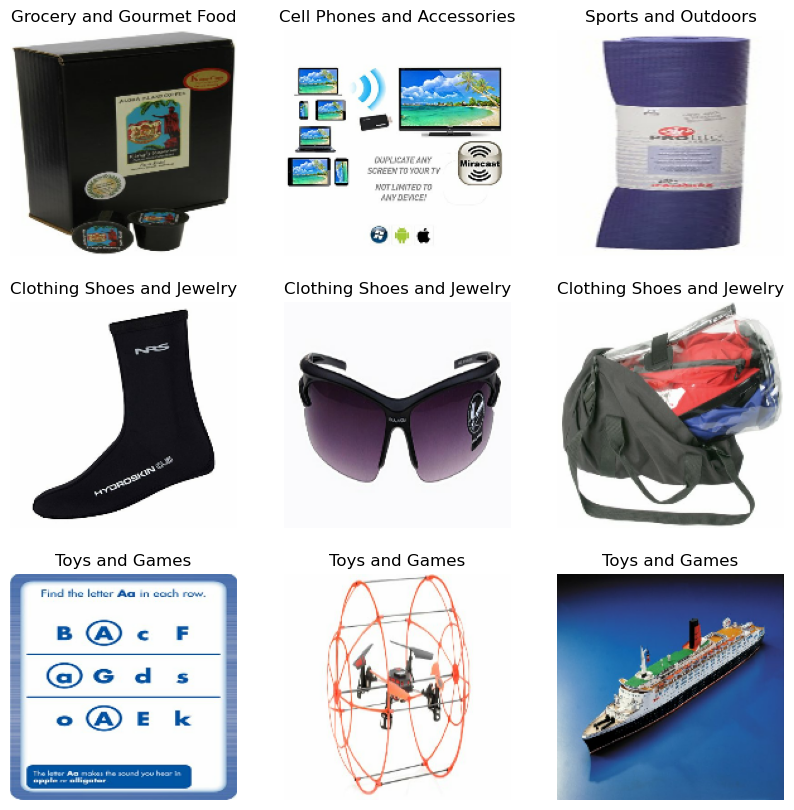

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2023-12-14 16:27:28.065678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


0.0 1.0


In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


117/117 [==============================] - 46s 389ms/step - loss: 1.5110 - accuracy: 0.3956 - val_loss: 1.2279 - val_accuracy: 0.5575
Epoch 2/10
117/117 [==============================] - 44s 378ms/step - loss: 1.0840 - accuracy: 0.6006 - val_loss: 1.1005 - val_accuracy: 0.6058
Epoch 3/10
117/117 [==============================] - 44s 379ms/step - loss: 0.8178 - accuracy: 0.7120 - val_loss: 1.0094 - val_accuracy: 0.6423
Epoch 4/10
117/117 [==============================] - 44s 380ms/step - loss: 0.5545 - accuracy: 0.8132 - val_loss: 1.0720 - val_accuracy: 0.6305
Epoch 5/10
117/117 [==============================] - 44s 380ms/step - loss: 0.3157 - accuracy: 0.8926 - val_loss: 1.3267 - val_accuracy: 0.6369
Epoch 6/10
117/117 [==============================] - 44s 379ms/step - loss: 0.1603 - accuracy: 0.9493 - val_loss: 1.3733 - val_accuracy: 0.6509
Epoch 7/10
117/117 [==============================] - 44s 380ms/step - loss: 0.1131 - accuracy: 0.9675 - val_loss: 1.5705 - val_accuracy: 0.6

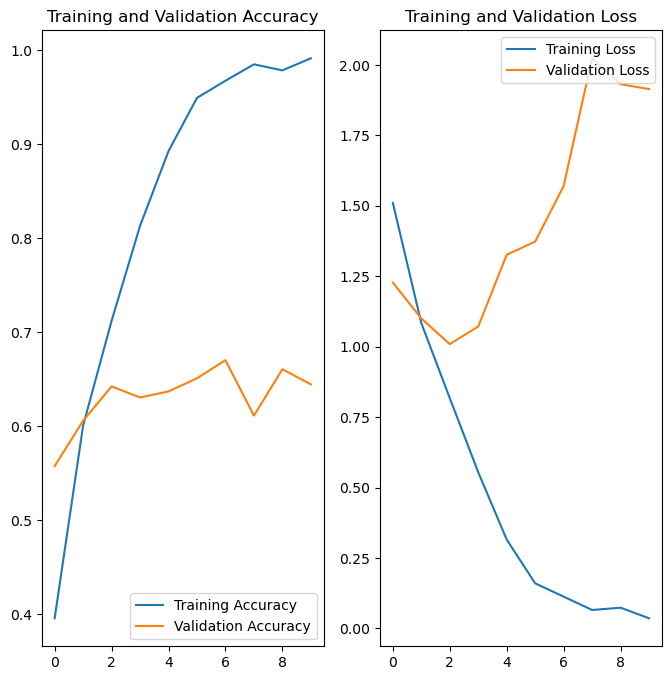

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

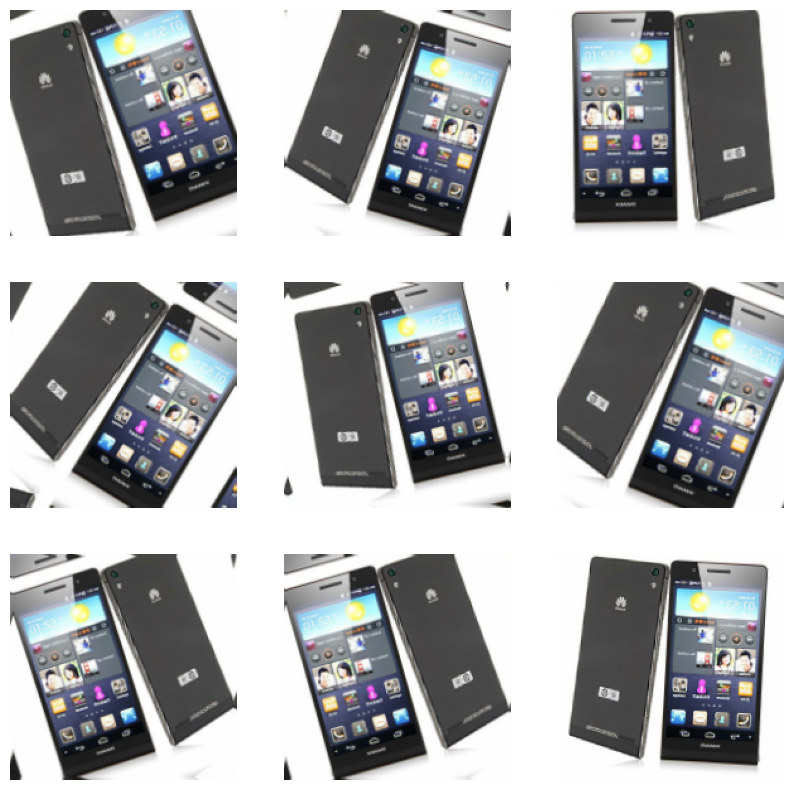

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
117/117 [==============================] - 50s 417ms/step - loss: 1.6946 - accuracy: 0.2670 - val_loss: 1.3801 - val_accuracy: 0.4393
Epoch 2/20
117/117 [==============================] - 49s 416ms/step - loss: 1.4347 - accuracy: 0.4334 - val_loss: 1.2770 - val_accuracy: 0.4919
Epoch 3/20
117/117 [==============================] - 49s 416ms/step - loss: 1.3004 - accuracy: 0.5046 - val_loss: 1.2898 - val_accuracy: 0.4984
Epoch 4/20
117/117 [==============================] - 49s 417ms/step - loss: 1.2223 - accuracy: 0.5319 - val_loss: 1.1363 - val_accuracy: 0.5822
Epoch 5/20
117/117 [==============================] - 49s 416ms/step - loss: 1.1456 - accuracy: 0.5612 - val_loss: 1.0821 - val_accuracy: 0.6230
Epoch 6/20
117/117 [==============================] - 49s 415ms/step - loss: 1.1147 - accuracy: 0.5811 - val_loss: 1.1032 - val_accuracy: 0.6122
Epoch 7/20
117/117 [==============================] - 49s 417ms/step - loss: 1.0809 - accuracy: 0.5974 - val_loss: 1.0770 - val_ac

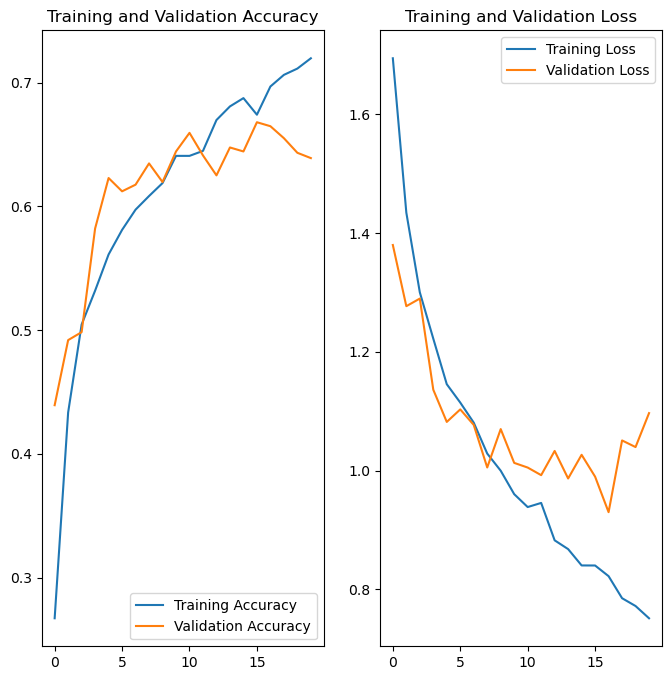

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

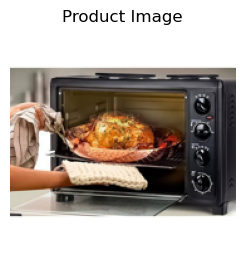

In [48]:
from PIL import Image
import matplotlib.pyplot as plt

test_prod_img = '/data/mohsin/Amazon Data/test_image/12.jpg'

# Open the image using Pillow
img = Image.open(test_prod_img)

# Resize the image to 180x180
img_resized = img.resize((180, 180))

plt.subplot(1, 2, 2)
plt.title('Product Image')
plt.imshow(img_resized)
plt.axis('off')

plt.show()


In [49]:
img = tf.keras.utils.load_img(
    test_prod_img, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to Electronics with a 82.23 percent confidence.
